# Gradient Boosting Classifier for Disaster Severity

This model implements a Gradient Boosting Classifier (GBC) to predict disaster severity based on historical data.

- Data Preprocessing:
    - Encoding categorical variables and standardizing numerical variables.
    - Data Normalization and Log-transformed for more accurate modeling.
- Modeling & Hyperparameter tunning:
    - Implementation of Gradient Boosting Classifier.
    - Hyperparameter tuning using RandomizedSearchCV.
- Feature Importance Analysis:
    - Calculates the importance of features using the GBC model and visualizes the top 10 important features.
- Performance Evaluation:
    - Evaluates the model's performance on the test data by computing accuracy and other metrics.
    
### Key Findings

- Hyperparameter Optimization:

- Best parameters found:
    - `n_estimators: 100` 
    - `subsample:  0.8` 
    - `max_depth: 7` 
    - `learning_rate: 0.05`     

- Test accuracy: **0.57**

- Model Performance:
    - When re-trained with optimal parameters, the test accuracy achieved was **57%**.

- Feature Importance:
    - The top features influencing the classification and their respective importance:
        1. Disaster Duration    0.205890
        2. Disaster Type_Road   0.192828

In [179]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# For random forest classification and evaluation
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import ConfusionMatrixDisplay

# For preprocessing data for model
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer

## Pre-process data 

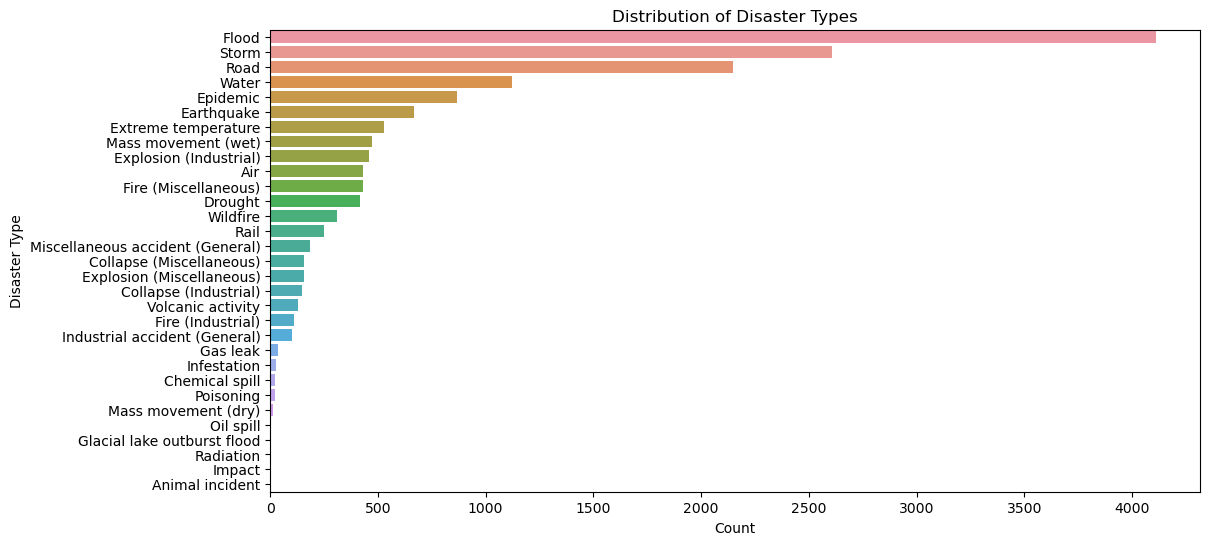

In [169]:
# Load the dataset
data_path = "./emdat_2020-2024_cleaned.csv" 
data = pd.read_csv(data_path)

# Test different attributes for classification
# data.head(5)

# Plot disaster type counts
plt.figure(figsize=(12, 6))
sns.countplot(y='Disaster Type', data=data, order=data['Disaster Type'].value_counts().index)
plt.title('Distribution of Disaster Types')
plt.xlabel('Count')
plt.ylabel('Disaster Type')
plt.show()

## Feature selection 

* Target variable: Total affected, total deaths 

* Possible Attributes for decision trees: 
    - Disaster Type
    - Region, subregion, country
    - Start month, start year, event duration, start month

Number of NaN values after log transformation: 4114
Number of values after log transformation: 15947


/opt/conda/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


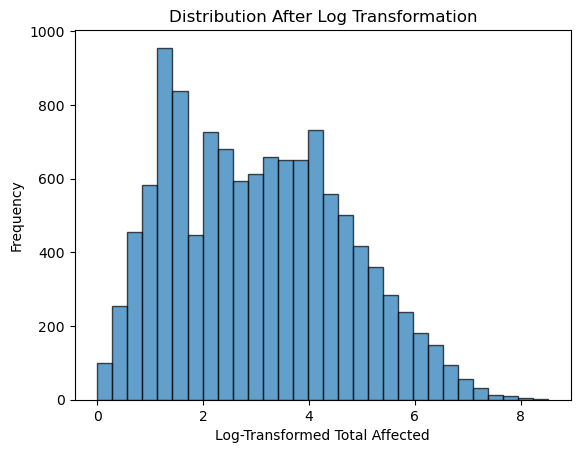

In [170]:
# Pick out the relevant Features for linear regression
relevant_features = [
    'Region', 'Subregion', 'Country',
    'Start Month', 'Disaster Duration', 'Disaster Type' #, 'Total Deaths'
]

# Add a small constant to avoid issues with non-positive values
data['Total Affected Log'] = np.log10(data['Total Affected'] + 1e-5)

# Check for NaN values
print(f"Number of NaN values after log transformation: {data['Total Affected Log'].isna().sum()}")
print(f"Number of values after log transformation: {len(data['Total Affected Log'])}")

# Do not use the NaN values for the GBC model 
data = data.dropna(subset=['Total Affected Log'])

# Visualize the distribution after log transformation
plt.hist(data['Total Affected Log'], bins=30, edgecolor='black', alpha=0.7)
plt.title("Distribution After Log Transformation")
plt.xlabel("Log-Transformed Total Affected")
plt.ylabel("Frequency")
plt.show()

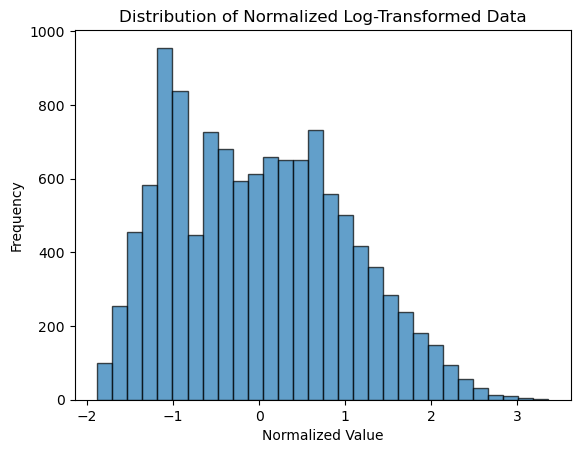

In [171]:
# After removing the NaN values from the log data 

# Normalize the log-transformed data
scaler = StandardScaler()
data['Total Affected Normalized Log'] = scaler.fit_transform(data[['Total Affected Log']])

# Visualize the normalized log-transformed data
plt.hist(data['Total Affected Normalized Log'], bins=30, edgecolor='black', alpha=0.7)
plt.title("Distribution of Normalized Log-Transformed Data")
plt.xlabel("Normalized Value")
plt.ylabel("Frequency")
plt.show()

In [172]:
# Define bins and labels based on log data 
bins = [-float('inf'), -1, 0, 1, 2, float('inf')]
labels = ['Very Low', 'Low', 'Moderate', 'High', 'Very High']

# Create new categories
data['Impact Category'] = pd.cut(data['Total Affected Normalized Log'], bins=bins, labels=labels)

# Separate features and target
X = data[relevant_features]
y = data['Impact Category']

print(data['Impact Category'].value_counts())

Low          3769
Moderate     3605
Very Low     2347
High         1791
Very High     321
Name: Impact Category, dtype: int64


In [173]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Identify numerical and categorical columns
cat_cols = X.select_dtypes(include=['object']).columns

# Apply One-Hot Encoding to the categorical columns
onehot = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
], remainder='passthrough')  # Keep numerical columns as they are


# Fit and transform the training and test datasets
X_train_encoded = onehot.fit_transform(X_train)
X_test_encoded = onehot.transform(X_test)

# print(y_train.isnull().sum())
# print(y_train.info())

# Display the transformed data shape
X_train_encoded.shape, X_test_encoded.shape

# X.info(), y.info()

((8283, 263), (3550, 263))

In [174]:
# Initialize and fit the model
gb_model = GradientBoostingClassifier(random_state=42)
gb_model.fit(X_train_encoded, y_train)

GradientBoostingClassifier(random_state=42)

In [175]:
# Make predictions
y_pred = gb_model.predict(X_test_encoded)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Print confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.57

Classification Report:
              precision    recall  f1-score   support

        High       0.52      0.38      0.44       493
         Low       0.57      0.43      0.49      1149
    Moderate       0.53      0.71      0.61      1088
   Very High       0.60      0.31      0.41        93
    Very Low       0.65      0.72      0.68       727

    accuracy                           0.57      3550
   macro avg       0.57      0.51      0.53      3550
weighted avg       0.57      0.57      0.56      3550


Confusion Matrix:
[[185  34 257  16   1]
 [ 11 499 359   0 280]
 [112 189 777   3   7]
 [ 43   2  19  29   0]
 [  2 156  45   0 524]]


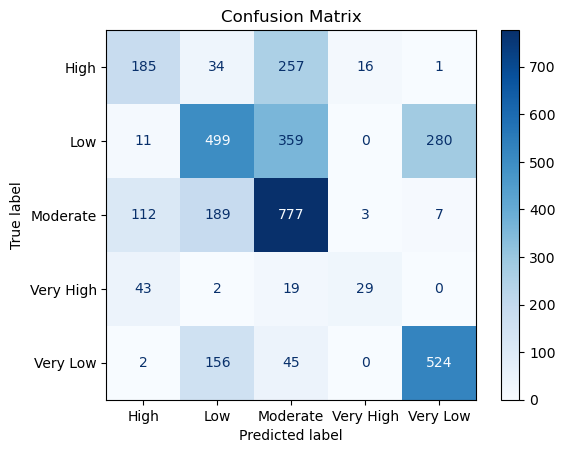

In [180]:
# Plot confusion matrix
ConfusionMatrixDisplay.from_estimator(gb_model, X_test_encoded, y_test, cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

### Check feature importance

Top 10 Important Features:
                           Feature  Importance
262   remainder__Disaster Duration    0.205890
256        cat__Disaster Type_Road    0.192828
243       cat__Disaster Type_Flood    0.084072
257       cat__Disaster Type_Storm    0.044139
235     cat__Disaster Type_Drought    0.042820
236  cat__Disaster Type_Earthquake    0.036223
237    cat__Disaster Type_Epidemic    0.036076
259       cat__Disaster Type_Water    0.032709
58              cat__Country_China    0.024660
261         remainder__Start Month    0.023607


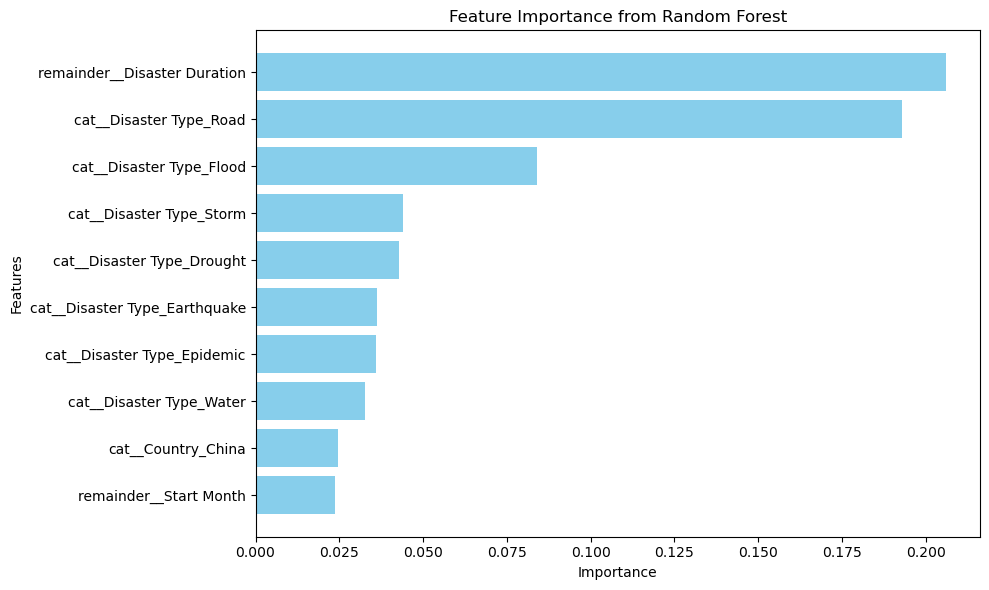

In [176]:
# Extract feature importances from the Random Forest model
importances = gb_model.feature_importances_

# Get feature names from the one hot encoder
feature_names = onehot.get_feature_names_out()

# Create a DataFrame to hold feature names and their corresponding importance scores
important_features = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Sort the features by importance
important_features = important_features.sort_values(by='Importance', ascending=False).head(10)

# Print the top 10 most important features
print("Top 10 Important Features:")
print(important_features.head(10))

# Plot the feature importance
plt.figure(figsize=(10, 6))
plt.barh(important_features['Feature'], important_features['Importance'], color='skyblue')
plt.gca().invert_yaxis()  # Invert y-axis to show the most important feature at the top
plt.title('Feature Importance from Random Forest')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.tight_layout()
plt.show()


## Results visualization

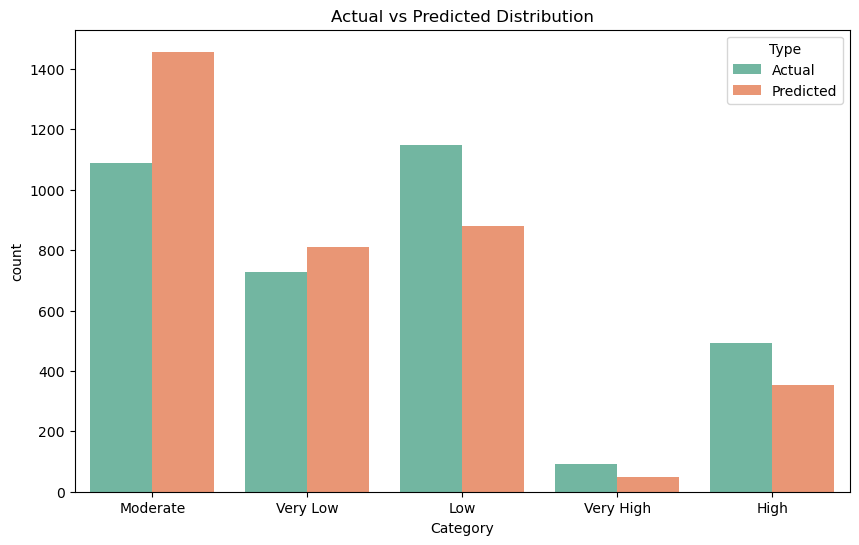

In [177]:
# Create a DataFrame for comparison
comparison_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})

# Count plot for Actual vs Predicted
plt.figure(figsize=(10, 6))
sns.countplot(data=comparison_df.melt(var_name='Type', value_name='Category'), 
              x='Category', hue='Type', palette='Set2')
plt.title("Actual vs Predicted Distribution")
plt.show()

# Hyperparameter tunning using randomized search 

In [182]:
# Parameter grid for randomized search
param_distributions = {
    'n_estimators': [50, 100, 150],    # Number of trees
    'learning_rate': [0.01, 0.05, 0.1],  # Shrinkage rate
    'max_depth': [3, 5, 7],           # Maximum tree depth
    'subsample': [0.8, 1.0],          # Fraction of samples used for fitting
}

# Initialize the model
gb_model = GradientBoostingClassifier(random_state=42)

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=gb_model,
    param_distributions=param_distributions,
    n_iter=10,  # Number of parameter combinations to try
    scoring='accuracy',  # Metric to optimize
    cv=3,  # 3-fold cross-validation
    random_state=42,
    verbose=2,  # Display progress
    n_jobs=-1  # Use all processors
)

# Fit the model
random_search.fit(X_train_encoded, y_train)

# Get the best parameters
best_params = random_search.best_params_
print("Best Parameters (Randomized Search):", best_params)

# Best model
best_model = random_search.best_estimator_

# Make predictions on the test set
y_pred = best_model.predict(X_test_encoded)

print(f"Test Set Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print("Classification Report:")
print(classification_report(y_test, y_pred))

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Parameters (Randomized Search): {'subsample': 0.8, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.05}
Test Set Accuracy: 0.57
Classification Report:
              precision    recall  f1-score   support

        High       0.49      0.41      0.45       493
         Low       0.57      0.48      0.52      1149
    Moderate       0.54      0.67      0.60      1088
   Very High       0.48      0.32      0.38        93
    Very Low       0.66      0.68      0.67       727

    accuracy                           0.57      3550
   macro avg       0.55      0.51      0.52      3550
weighted avg       0.57      0.57      0.56      3550

[CV] END learning_rate=0.05, max_depth=3, n_estimators=50, subsample=1.0; total time=   1.3s
[CV] END learning_rate=0.1, max_depth=7, n_estimators=50, subsample=1.0; total time=   2.9s
[CV] END learning_rate=0.1, max_depth=7, n_estimators=50, subsample=0.8; total time=   2.8s
[CV] END l